In [1]:
import pickle
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import glob as glob
import os
import scipy
import sys; sys.path.append("../../..")  # Allows access to all the scripts/modules in the larger directory
from utils import calc_loadings
from collections import defaultdict
from sklearn.cross_decomposition import CCA
from sklearn.model_selection import KFold


### Load consolidated dimreduc dataframe

In [2]:
dimreduc_glom_path = '/home/marcush/Data/TsaoLabData/neural_control_output_new/dimreduc_deg_230322_214006_Jamie/dimreduc_deg_230322_214006_Jamie_glom.pickle'
with open(dimreduc_glom_path, 'rb') as f:
    dat = pickle.load(f) 

df_dimreduc = pd.DataFrame(dat)

### Load the processed data from both regions

In [3]:
def make_hashable(obj):
    if isinstance(obj, dict):
        return tuple(sorted((key, make_hashable(value)) for key, value in obj.items()))
    elif isinstance(obj, (list, tuple)):
        return tuple(make_hashable(item) for item in obj)
    else:
        return obj


unique_hashes = set(make_hashable(d) for d in df_dimreduc['full_arg_tuple'])
unique_dicts = [dict(u) for u in unique_hashes]
preload_dict_path = df_dimreduc['data_path'][0] + "/preloaded/preloadDict.pickle"

with open(preload_dict_path, 'rb') as file:
    preloadDict = pickle.load(file)

In [4]:
for arg_dict in unique_dicts:
    arg_tuple = tuple(sorted(arg_dict.items()))


    for args in preloadDict.keys():

        if args == arg_tuple:

            preloadID = preloadDict[arg_tuple]
            loaded_data_path = os.path.dirname(preload_dict_path) + f"/preloaded_data_{preloadID}.pickle"
            
            if arg_dict['region'] == 'AM':
                with open(loaded_data_path, 'rb') as file:
                    AM_loaded_data = pickle.load(file)

            elif arg_dict['region'] == 'ML':
                with open(loaded_data_path, 'rb') as file:
                    ML_loaded_data = pickle.load(file)

AM_spikes = np.sum(AM_loaded_data['spike_rates'], 1)
ML_spikes = np.sum(ML_loaded_data['spike_rates'], 1)

### Find saturating CCA dimensionality

In [10]:
RELOAD = False
save_path_cca_corrs = f'./CCA_structs/cca_corrs.pkl'

In [11]:
X = ML_spikes
Y = AM_spikes
max_cca_dim_check = 250

if RELOAD:
    fold_splits = np.unique(df_dimreduc['fold_idx'].values)
    nSplits = len(fold_splits)
    canonical_correlations = np.zeros((nSplits, max_cca_dim_check))

    for split in fold_splits: 

        train_idxs, test_idxs = list(KFold(n_splits=nSplits).split(X))[split]

        x = X[train_idxs]
        y = Y[train_idxs]

        cca = CCA(n_components=max_cca_dim_check, max_iter=1000)
        cca.fit(x, y)
        X_c, Y_c = cca.transform(x, y)

        canonical_correlations[split, :] = [scipy.stats.pearsonr(X_c[:, i], Y_c[:, i])[0] for i in range(max_cca_dim_check)]

        print(f"Done with split {split+1} of {nSplits}")

    with open(save_path_cca_corrs, 'wb') as f:
        pickle.dump(canonical_correlations, f)

else:
    
    with open(save_path_cca_corrs, 'rb') as f:
        canonical_correlations = pickle.load(f)
    print("Loading previous CCA fit to split data.")


Done with split 1 of 5
Done with split 2 of 5
Done with split 3 of 5
Done with split 4 of 5
Done with split 5 of 5


Text(0.5, 0, 'Dimension')

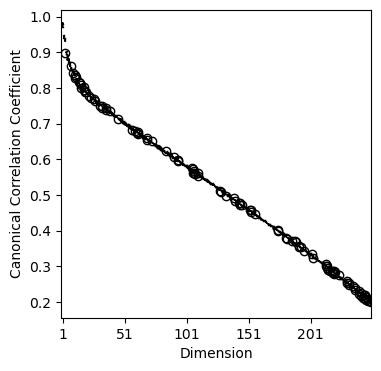

In [12]:
fig, ax = plt.subplots(figsize=(4, 4))

medianprops = dict(linewidth=0)
bplot = ax.boxplot(np.reshape(canonical_correlations, (-1, max_cca_dim_check)), patch_artist=True, medianprops=medianprops, notch=True)
nTicks = 50
ax.set_xticks(np.arange(1, max_cca_dim_check, nTicks))
ax.set_xticklabels(np.arange(1, max_cca_dim_check, nTicks))
ax.set_xlim([0, max_cca_dim_check])
ax.set_ylabel('Canonical Correlation Coefficient')
ax.set_xlabel('Dimension')

# Use BIC to determine optimal CCA dimensionality

In [13]:
# p <= q
def CC_AIC(cc_coefs, N, p, q):
    # Sort in descending order
    cc_coefs = np.sort(cc_coefs)[::-1]

    # Calculate the vector Ak
    Ak = np.array([-N * np.sum(np.log(1 - np.power(cc_coefs[k + 1:], 2))) -2 * (p - k) * (q - k) for k in range(cc_coefs.size - 1)])
    return Ak

def CC_BIC(cc_coefs, N, p, q):
    # Sort in descending order
    cc_coefs = np.sort(cc_coefs)[::-1]

    # Calculate the vector Ak
    Ak = np.array([-N * np.sum(np.log(1 - np.power(cc_coefs[k + 1:], 2))) -np.log(N) * (p - k) * (q - k) for k in range(cc_coefs.size - 1)])
    return Ak

In [14]:
X = ML_spikes
Y = AM_spikes


fold_splits = np.unique(df_dimreduc['fold_idx'].values)
nSplits = len(fold_splits)
cc_dim = np.zeros((nSplits, 2))


for split in fold_splits: 

    train_idxs, test_idxs = list(KFold(n_splits=nSplits).split(X))[split]

    x = X[train_idxs]
    y = Y[train_idxs]

    p = min(x.shape[1], y.shape[1])
    q = max(x.shape[1], y.shape[1])

    Ak = CC_AIC(canonical_correlations[split, :], x.shape[0], p, q)
    cc_dim[split, 0] = np.argmin(Ak)
    Ak = CC_BIC(canonical_correlations[split, :], x.shape[0], p, q)    
    cc_dim[split, 1] = np.argmin(Ak)

Text(0, 0.5, 'Dimension')

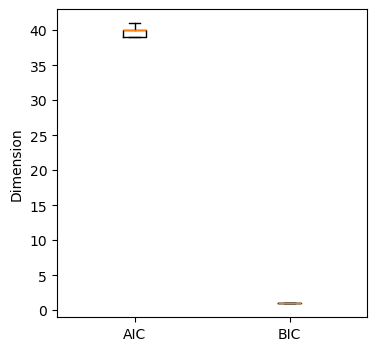

In [15]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.boxplot(cc_dim + 1)
ax.set_xticklabels(['AIC', 'BIC'])
ax.set_ylabel('Dimension')

In [16]:
print(f"Optimal CCA Dim: {np.median(cc_dim[:,0])}")

Optimal CCA Dim: 39.0


### Compute and Save CCA Matrices

In [17]:
manual_CCA_dim = 39 #np.inf 

cca_dims = np.min((manual_CCA_dim, AM_spikes.shape[-1], ML_spikes.shape[-1])).astype(int)

ccamodel = CCA(n_components=cca_dims, max_iter=1000)
ccamodel.fit(ML_spikes, AM_spikes)

cca_save_path = os.path.dirname(df_dimreduc['results_file'][0]) + f"/CCA_{cca_dims}_dims.pickle"

with open(cca_save_path, 'wb') as file:
    pickle.dump(ccamodel, file)